# Titanic Data Analysis

A look at Kaggle's Titanic dataset. In this notebook I will be cleaning both the train and test sets and using SciKit to form predictive models.

In [451]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

# set float values to display to 2 d.p. only
pd.options.display.float_format = "{:,.2f}".format

# load titanic data
titanic_train = pd.read_csv("./data/train.csv")
titanic_test = pd.read_csv("./data/test.csv")
gender_submission = pd.read_csv("./data/gender_submission.csv")

# create full dataset and reset indices
titanic_full = titanic_train.append(titanic_test, sort=False).reset_index()
titanic_full = titanic_full.drop(["index"], axis=1)
titanic_full.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.00,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1.00,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1.00,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1.00,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0.00,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


# Cleaning the Data

First, I want to check the whole dataset to see if there are any significant gaps. For ease of identification I am going to generate a heatmap that indicates missing data values for each column (yellow indicates missing values).

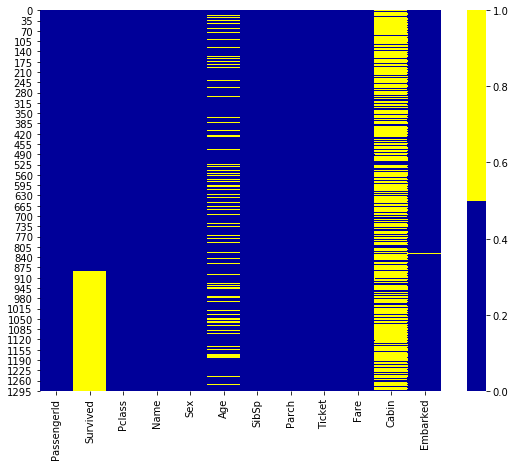

In [452]:
# Visualise missing data from each column. This is to identify columns that might be worth removing. 
colours = ['#000099', '#ffff00']
plt.figure(figsize=(9,7))
sns.heatmap(titanic_full.isnull(), cmap=sns.color_palette(colours))

The heatmap shows there is a large absence of data in the Cabin field. This is not numeric data and therefore cannot be replaced with median values, so I will drop it from the dataset. The missing Age fields can be filled out with a median average. Name, Passenger ID and Ticket fields represent no real value to the analysis, so they will also be dropped.

In [453]:
# Remove Passenger ID, Cabin, Name and Ticket columns
titanic_full_cln = titanic_full.drop(["Cabin", "Name", "Ticket", "PassengerId"], axis=1)

# Replace age NaNs with average age
titanic_full_cln['Age'] = titanic_full_cln['Age'].fillna(titanic_full_cln['Age'].median())

titanic_full_cln.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.00,3,male,22.00,1,0,7.25,S
1,1.00,1,female,38.00,1,0,71.28,C
2,1.00,3,female,26.00,0,0,7.92,S
3,1.00,1,female,35.00,1,0,53.10,S
4,0.00,3,male,35.00,0,0,8.05,S


Next, I will be checking for outliers in the continuous data columns. I can do this by creating boxplots for my continuous data fields and checking to see which values lie outside the 'minimum' and 'maximum' ranges (the black lines at the ends of each plot).

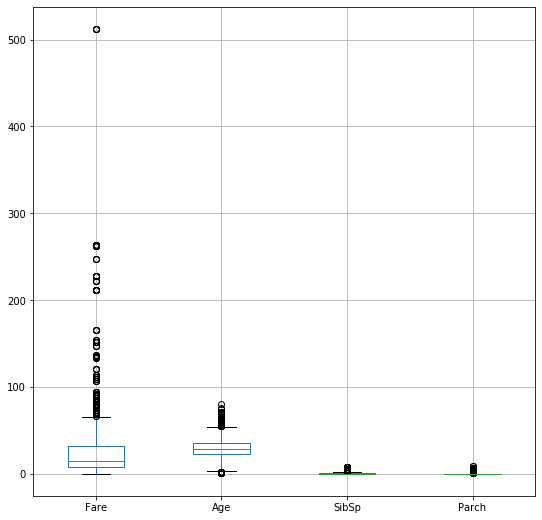

In [454]:
titanic_full_cln.boxplot(column=['Fare', 'Age', 'SibSp', 'Parch'], figsize=(9,9))

In the 'Fare' feature there are some outliers well in excess of 500. I suspect that these outliers indicate passengers who purchased tickets as part of a group, as they all paid the same fee at an extremely high price. As this is only a small group of outliers, removing them is unlikely to change the outcome of the data analysis. Therefore, I am going to trim the dataset to exclude these points. 

In [455]:
# remove fare outliers
titanic_full_cln = titanic_full_cln[titanic_full_cln['Fare'] < 300]

Before proceeding with visualisation and modelling, I need to ensure that every value is numeric. Therefore, I am going to map the Sex string values ('male', 'female') to numeric values. 

In [456]:
m_f_mapping = {'male': 1, 'female': 2}
titanic_full_cln = titanic_full_cln.replace({'Sex': m_f_mapping})

Finally, I will combine the SibSp and Parch fields into a common 'Relatives' column.

In [457]:
titanic_full_cln['Relatives'] = titanic_full_cln['SibSp'] + titanic_full_cln['Parch']
titanic_full_cln = titanic_full_cln.drop(['SibSp', 'Parch', 'Embarked'], axis=1)

# Visualising Features

I am going to investigate the relationship between a passenger's survival and two features from the dataset (age and fare paid). First, I am going to separate the data into training and test sets (only the train set has labels):

In [458]:
# Isolate desired features in separate DataFrame
titanic_train = titanic_full_cln[titanic_full_cln['Survived'].notnull()].reset_index().drop(['index'], axis=1)
titanic_test = titanic_full_cln[titanic_full_cln['Survived'].isnull()].reset_index()
titanic_train

,Survived,Pclass,Sex,Age,Fare,Relatives
0,0.00,3,1,22.00,7.25,1
1,1.00,1,2,38.00,71.28,1
2,1.00,3,2,26.00,7.92,0
3,1.00,1,2,35.00,53.10,1
4,0.00,3,1,35.00,8.05,0
...,...,...,...,...,...,...
883,0.00,2,1,27.00,13.00,0
884,1.00,1,2,19.00,30.00,0
885,0.00,3,2,28.00,23.45,3
886,1.00,1,1,26.00,30.00,0


## Scatter Plot Example: Age vs. Fare

Below, a scatter plot showing the passengers' age against the cost of their fare. The color of the points indicates survival status.

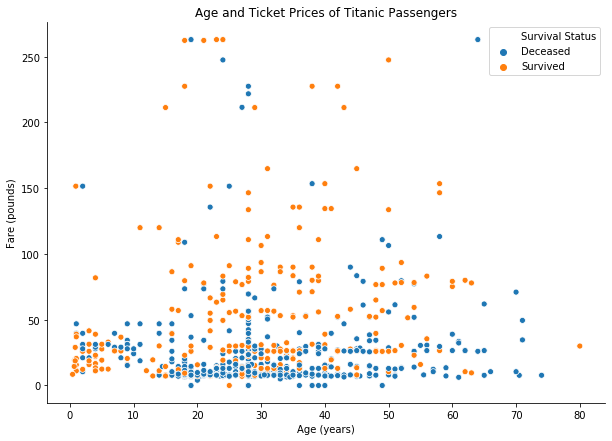

In [459]:
train_survivors = titanic_train[titanic_train['Survived'] == 1]
train_non_survivors = titanic_train[titanic_train['Survived'] == 0]

# create Survival Status string values for legend readability
survival_mapping = {0: "Deceased", 1: "Survived"}
titanic_train['Survival Status'] = titanic_train['Survived'].map(survival_mapping)

# plot scatter graph
plt.figure(figsize=(10,7))
sns.scatterplot(data=titanic_train, x='Age', y='Fare', hue='Survival Status')
plt.title('Age and Ticket Prices of Titanic Passengers')
plt.xlabel("Age (years)")
plt.ylabel('Fare (pounds)')

sns.despine()


Visually there appears to be a relationship between a passenger's ticket price and their survival.

## Feature Correlation Heatmap

Below is a heatmap showing the relationship between each feature:

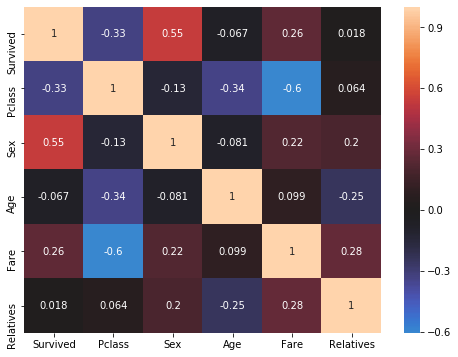

In [460]:
plt.figure(figsize=(8,6))

# plot heatmap
corr = titanic_train.corr()
ax = sns.heatmap(corr, annot=True, center=0) 
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

The heatmap implies a moderate correlation between a passenger's sex and their chance of survival. It also outlines a slight positive correlation between their ticket price and survival. There is a strong negative correlation between fares and passenger class - this is because class 1 tickets will have cost more than class 3 tickets!

In the next step I will be using machine learning practices to further investigate these relationships. 

# Machine Learning: Predicting Survival Probability

## Feature Selection

First, I will use univariate feature selection to select the 2 best features to predict the outcome with. Before doing this, I will have to standardise the data, i.e. rescale every feature distribution so that their values lie on a range of 0 to 1. This will help improve feature selection accuracy. 

In [461]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# import float formatting options
from numpy import set_printoptions
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# split data into X (features) and Y (outcomes), convert both to numpy arrays for standardisation
X = titanic_train.drop(["Survived", "Survival Status"], axis=1).to_numpy()
y = titanic_train["Survived"].to_numpy()

# set up mix-max data scaler and transform data
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)

X_scale

array([[1.000000, 0.000000, 0.271174, 0.027567, 0.100000],
       [0.000000, 1.000000, 0.472229, 0.271039, 0.100000],
       [1.000000, 1.000000, 0.321438, 0.030133, 0.000000],
       ...,
       [1.000000, 1.000000, 0.346569, 0.089163, 0.300000],
       [0.000000, 0.000000, 0.321438, 0.114068, 0.000000],
       [1.000000, 0.000000, 0.396833, 0.029468, 0.000000]])

Next, I will determine the best features for modelling using SciKit's SelectKBest algorithm:

In [462]:
# select 2 best features
test = SelectKBest(chi2, k=2)
fit = test.fit(X_scale, y)

features = titanic_train.drop(["Survived", 'Survival Status'], axis=1).columns

# summarise feature scores
print("Feature Scores:")
for i, score in enumerate(fit.scores_):
    print(features[i]+":", score)

Feature Scores:
Pclass: 26.219027067092796
Sex: 171.35344649778983
Age: 0.29475084848826444
Fare: 12.80977212985237
Relatives: 0.0847021568074428


#### Features Ranked by Importance:

1. Sex
2. Pclass
3. Fare
4. Age
5. Relatives

The feature selection algorithms determined that Sex, PClass and Fare are the three most useful features when evaluating a passenger's survival. These scores supports the values produced by the correlation matrix shown earlier. 

Below is a categorical scatter plot of Sex vs Fare. I have decided against plotting the PClass feature as its categorical natures does not tell us as much about individual passengers, and already correlates strongly with Fare. 

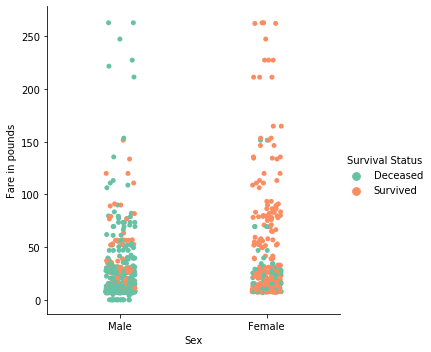

In [463]:
sns.catplot(data=titanic_train, x='Sex', y='Fare', hue='Survival Status', palette="Set2")
plt.ylabel("Fare in pounds")
plt.xlabel("Sex")
plt.xticks(np.arange(0,2), ('Male', 'Female'))

plt.show()

This plot shows a clear relationship between Sex and Survival Status - women were statistically more likely to have survived the disaster. This is supported by the correlation matrix shown in the previous section. Through the processes of standardisation and feature selection, I have been able to identify a passenger's sex as a highly important feature in determining survival.

In the next section, I am going to use the strongest continuous variable (Fare) to train a logistic regression model. I will then plot the results on a scatter graph. 

## Plotting a Decision Boundary using Logistic Regression

Here I attempt to draw a classification boundary for the Fare feature. This will be done using Logistic Regression - a means of predicting categorical values. 

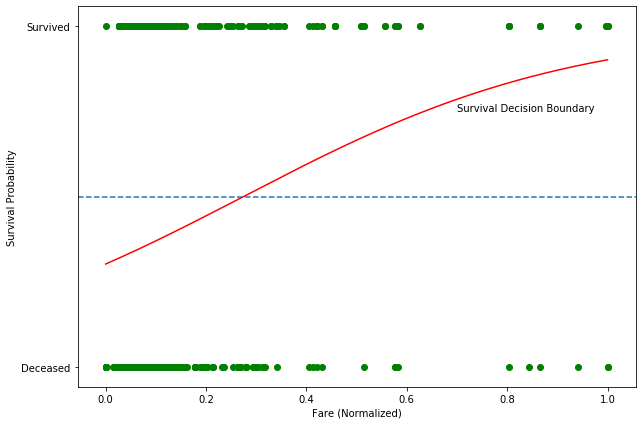

In [464]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs')

# convert X_scale np array back to pandas and isolate feature columns
X_df_scale = pd.DataFrame(X_scale, columns = features)
X_np_scale = X_df_scale['Fare'].to_numpy().reshape(-1, 1)

# generate series of x values for plotting fit line
X_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# fit model and predict probabilities of 'test' values for fitting line
clf.fit(X_np_scale, y)
predict_probas = clf.predict_proba(X_test)[:, 1]

# plot data points and fitting line
plt.figure(figsize=(10,7))
plt.scatter(X_df_scale.Fare, y, color='green')
plt.plot(X_test, predict_probas, color='red')
plt.axhline(y=0.5, linestyle='--')

# add labels
plt.xlabel("Fare (Normalized)")
plt.ylabel("Survival Probability")
plt.yticks([0, 1], ["Deceased", "Survived"])
plt.text(0.7, 0.75, "Survival Decision Boundary")
plt.show()

The red line represents the survival probability predicted by the model across every possible x value.

The dashed blue line represents a probability of 0.5. A data point with survival probability above 0.5 indicates they are predicted to survive, and under 0.5 indicates they are predicted to have died.

## Evaluating The Classifier

A logistic classifier cannot be evaluated in the same way as a linear classifier (by computing r-squared values). Instead, we can plot a confusion matrix to show correct and false predictions for each classification.

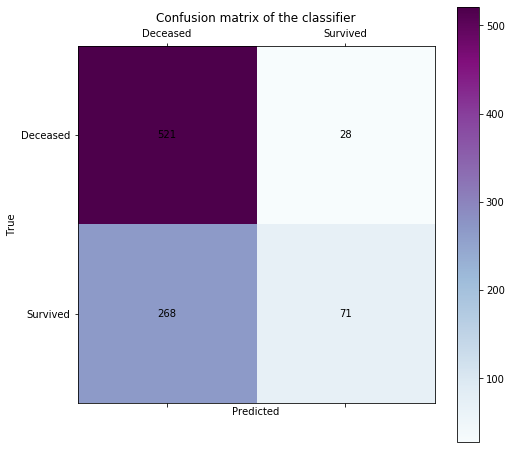

In [465]:
from sklearn.metrics import confusion_matrix

# generate predicted and actual values for the confusion matrix
class_preds = clf.predict(X_np_scale)
class_actual = y

labels = ['Deceased', 'Survived']

cm = confusion_matrix(class_actual, class_preds)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap="BuPu")
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix of the classifier')

width, height = cm.shape

for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), horizontalalignment='center', verticalalignment='center')

plt.show()


Below we compute precision, recall and F1 scores for this classifier:

In [476]:
from sklearn.metrics import f1_score, precision_score, recall_score

labels = ['Precision Score', "Recall Score", "F1 Score"]

precision = precision_score(class_actual, class_preds)
recall = recall_score(class_actual, class_preds)
f1 = f1_score(class_actual, class_preds)

scores = [precision, recall, f1]

for i, score in enumerate(scores):
    print(labels[i]+":", score)

Precision Score: 0.7171717171717171
Recall Score: 0.20943952802359883
F1 Score: 0.3242009132420091


The F1 score indicates a sub-par classification model with plenty of false negative classifications. The fare paid by a passenger correlates mildly to their survival, but is not a suitable predictor. This is 